# Propensity Score Estimation Methods
---
## The four steps of causal inference

### I. Model a causal problem
- Create a causal DAG for your system of interest.

### II. Identify a target estimand under the model
- Identify the causal estimand under the assumptions of the causal DAG.

### III. Estimate the causal effect based on the identified estimand
- Estimate the estimand using any kind of Stats/ML model e.g. linear regression, random forest etc.

### IV. Refute the obtain estimate
- Peform refutations on the estimate to test its robustness 

In [1]:
import numpy as np
import pandas as pd
import patsy as ps
import statsmodels
import dowhy
from dowhy import CausalModel
import econml
from IPython.display import Image, display
from pathlib import Path
import os
import sys
import matplotlib.pyplot as plt

# Avoid printing dataconversion warnings from sklearn
# Config dict to set the logging level
import logging.config
import warnings
warnings.filterwarnings('ignore')
DEFAULT_LOGGING = {
    'version': 1,
    'disable_existing_loggers': False,
    'loggers': {
        '': {
            'level': 'WARN',
        },
    }
}
logging.config.dictConfig(DEFAULT_LOGGING)

# Import custom dowhy helper functions module
cwd = Path().resolve()
PARENT_DIR = os.path.dirname(cwd)
SCRIPT_DIR = os.path.join(PARENT_DIR, 'helpers')
sys.path.append(SCRIPT_DIR)
import dowhy_helpers as dwh

In [2]:
# I/O Stuff
DATA_FILENAME = "csdh_clean.csv"
DATA_FILEPATH = "/Users/callum/Uni/GitHubRepos/surviving-the-icu/datasets/drain_data/" + DATA_FILENAME
csdh = pd.read_csv(DATA_FILEPATH)

---
## 0. Naïve Estimation (no causal inference)

In [3]:
# Mask treatment variable as bool 
# DoWhy is still in development and does not support int treatments for propensity_score_weighting
csdh['drain'] = csdh['drain'].astype(bool)

naive_est = dwh.naive_estimate(df=csdh, treatment='drain', outcome='recurrence', treatment_type='int')
print(f"Without adjusting for any confounding, the naive causal estimate is computed as {naive_est}")

Without adjusting for any confounding, the naive causal estimate is computed as -0.09356128931064231


---
## I. Model a causal problem
* Create a causal model from the data and given graph.

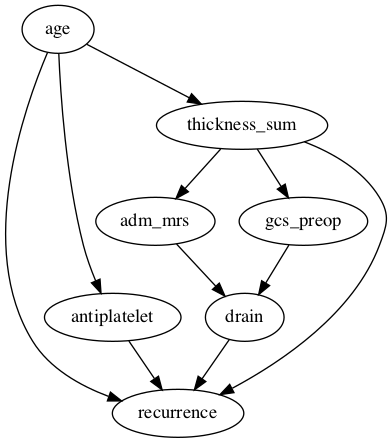

In [4]:
mp_model = CausalModel(data=csdh, 
                       treatment='drain', 
                       outcome='recurrence', 
                       graph='../causal_graphs/mp_dag.dot'.replace("\n", " "))
mp_model.view_model()
display(Image(filename="causal_model.png"))

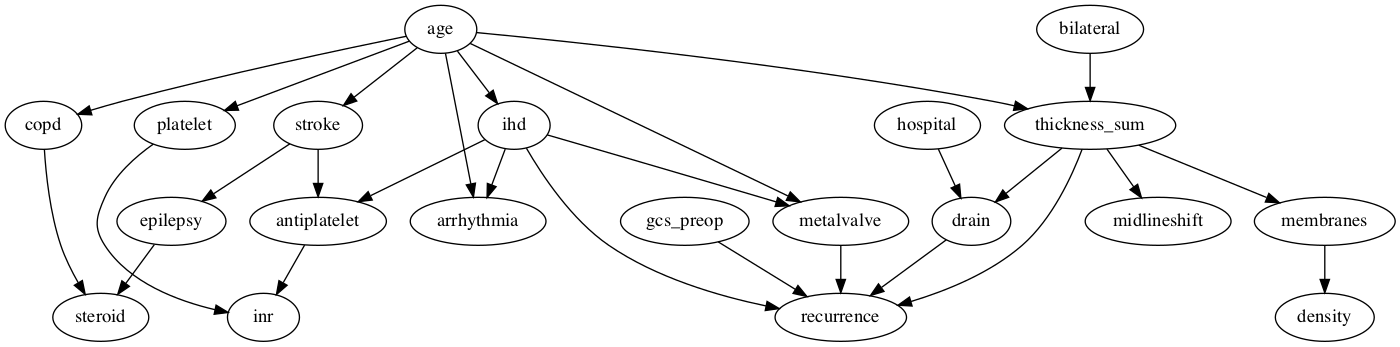

In [5]:
data_model = CausalModel(data=csdh, 
                         treatment='drain', 
                         outcome='recurrence', 
                         graph='../causal_graphs/data_dag.dot'.replace("\n", " "))
data_model.view_model()
display(Image(filename="causal_model.png"))

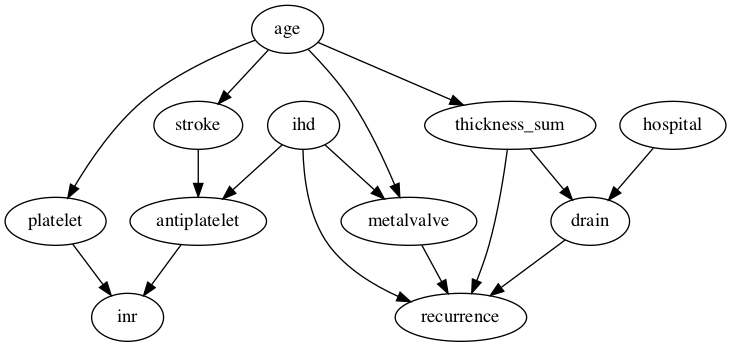

In [6]:
small_data_model = CausalModel(data=csdh,
                               treatment='drain', 
                               outcome='recurrence', 
                               graph='../causal_graphs/small_data_dag.dot'.replace("\n", " "))
small_data_model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

---
## II. Identify a target estimand under the model

In [7]:
mp_estimand = mp_model.identify_effect(proceed_when_unidentifiable=True)
data_estimand = data_model.identify_effect(proceed_when_unidentifiable=True)
small_data_estimand = small_data_model.identify_effect(proceed_when_unidentifiable=True)

---
## III. Propensity Score Weighting Estimator
### Inverse probability weighting (IPW) has been chosen


In [9]:
# Propensity score matching
mp_weight_est = mp_model.estimate_effect(mp_estimand,
                                         method_name="backdoor.propensity_score_weighting",
                                         control_value=False,
                                         treatment_value=True,
                                         test_significance=True,
                                         confidence_intervals=True,
                                         method_params={"weighting_scheme":"ips_weight"}
                                        )

In [10]:
data_weight_est = data_model.estimate_effect(data_estimand,
                                             method_name="backdoor.propensity_score_weighting",
                                             control_value=False,
                                             treatment_value=True,
                                             test_significance=True,
                                             confidence_intervals=True,
                                             method_params={"weighting_scheme":"ips_weight"}
                                            )

In [11]:
sdata_weight_est = small_data_model.estimate_effect(small_data_estimand,
                                                    method_name="backdoor.propensity_score_weighting",
                                                    control_value=False,
                                                    treatment_value=True,
                                                    test_significance=True,
                                                    confidence_intervals=True,
                                                    method_params={"weighting_scheme":"ips_weight"}
                                                   )

In [12]:
print(mp_weight_est)
print(data_weight_est)
print(sdata_weight_est)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                                          
────────(Expectation(recurrence|adm_mrs,gcs_preop,age,thickness_sum,antiplatel
d[drain]                                                                      

    
et))
    
Estimand assumption 1, Unconfoundedness: If U→{drain} and U→recurrence then P(recurrence|drain,adm_mrs,gcs_preop,age,thickness_sum,antiplatelet,U) = P(recurrence|drain,adm_mrs,gcs_preop,age,thickness_sum,antiplatelet)

## Realized estimand
b: recurrence~drain+adm_mrs+gcs_preop+age+thickness_sum+antiplatelet
Target units: ate

## Estimate
Mean value: -0.11267092494077242
p-value: 0.001
95.0% confidence interval: (-0.16962328444516067, -0.04610915429100021)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression

In [13]:
# mp model
dwh.print_estimate_comparison(naive_est, mp_weight_est, 'IPW')

-------------- Causal Estimates -------------- 
Naive causal estimate is -0.09356128931064231
IPW causal estimate is -0.11267092494077242
Percentage change from naive_est: 20.425%
----------------------------------------------


In [14]:
# data model
dwh.print_estimate_comparison(naive_est, data_weight_est, 'IPW')

-------------- Causal Estimates -------------- 
Naive causal estimate is -0.09356128931064231
IPW causal estimate is -0.12135455420371477
Percentage change from naive_est: 29.706%
----------------------------------------------


In [15]:
# small data model
dwh.print_estimate_comparison(naive_est, sdata_weight_est, 'IPW')

-------------- Causal Estimates -------------- 
Naive causal estimate is -0.09356128931064231
IPW causal estimate is -0.11129408031591095
Percentage change from naive_est: 18.953%
----------------------------------------------


---
### III. IPW Interpreters

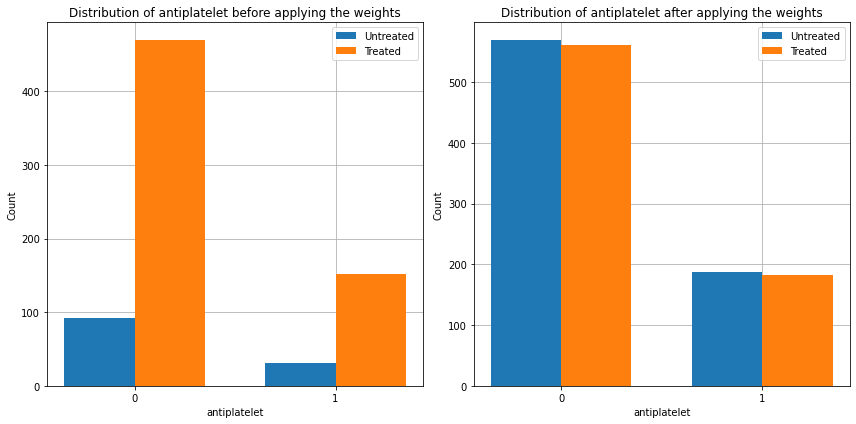

In [16]:
dwh.plot_ipw_interpreter(mp_weight_est, 'antiplatelet')

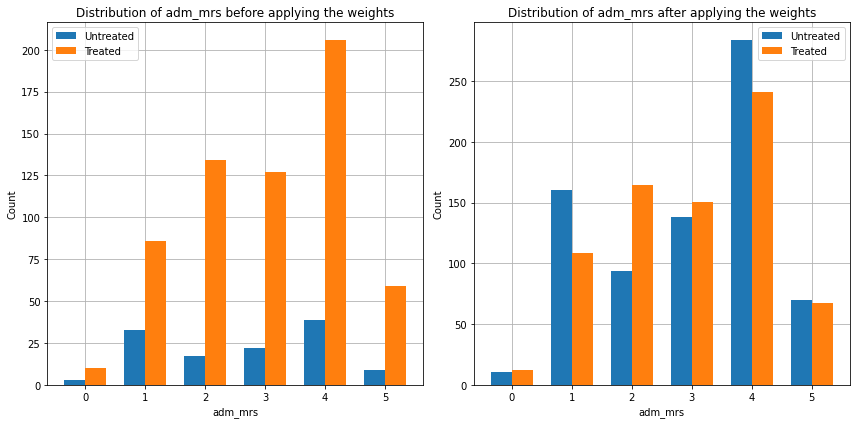

In [17]:
dwh.plot_ipw_interpreter(mp_weight_est, 'adm_mrs')

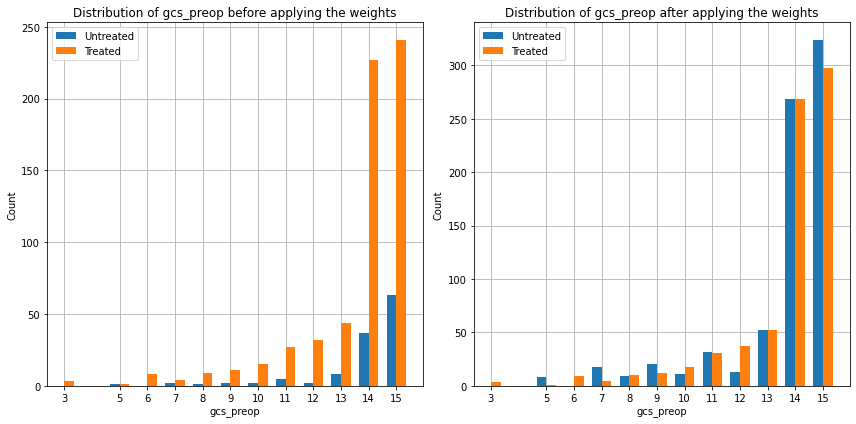

In [18]:
dwh.plot_ipw_interpreter(mp_weight_est, 'gcs_preop')

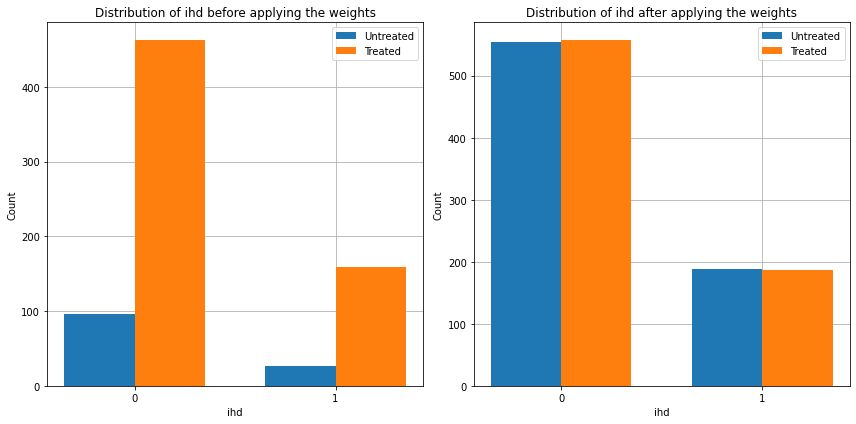

In [19]:
dwh.plot_ipw_interpreter(data_weight_est, 'ihd')

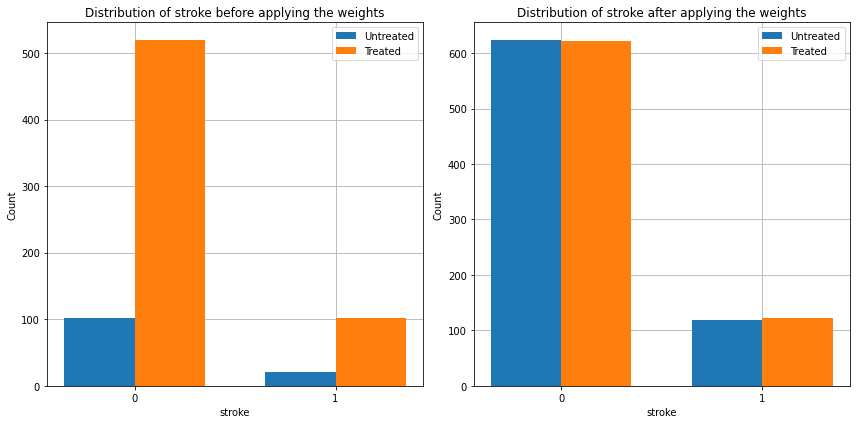

In [20]:
dwh.plot_ipw_interpreter(sdata_weight_est, 'stroke')

---
## IV. Refute the obtained estimate

1. **Add Random Common Cause:** Does the estimation method change its estimate after we add an independent random variable as a common cause to the dataset? (Hint: It should not)

In [27]:
mp_ran_weight_refuter = mp_model.refute_estimate(mp_estimand, 
                                                 mp_weight_est, 
                                                 num_simulations=2,
                                                 method_name='random_common_cause')

In [28]:
data_ran_weight_refuter = data_model.refute_estimate(data_estimand, 
                                                     data_weight_est, 
                                                     num_simulations=2,
                                                     method_name='random_common_cause')

In [29]:
sdata_ran_weight_refuter = small_data_model.refute_estimate(small_data_estimand, 
                                                            sdata_weight_est,
                                                            num_simulations=2,
                                                            method_name='random_common_cause')

In [30]:
# Robust if: new estimate is similar to estimated effect
print(mp_ran_weight_refuter)
print(data_ran_weight_refuter)
print(sdata_ran_weight_refuter)

Refute: Add a Random Common Cause
Estimated effect:-0.11267092494077242
New effect:-0.11238603813849474

Refute: Add a Random Common Cause
Estimated effect:-0.12135455420371477
New effect:-0.11859439497732174

Refute: Add a Random Common Cause
Estimated effect:-0.11129408031591095
New effect:-0.1154718756756758



2. **Placebo Treatment:** What happens to the estimated causal effect when we replace the true treatment variable with an independent random variable? (Hint: the effect should go to zero)


- Note that the placebo type is 'permute' meaning the rows of the treatment variable have been randomly permuted giving the effect of a placebo treatment.

In [31]:
mp_placebo_weight_refuter = mp_model.refute_estimate(mp_estimand, 
                                                     mp_weight_est,
                                                     placebo_type='permute',
                                                     num_similations=2,
                                                     method_name='placebo_treatment_refuter')

In [32]:
data_placebo_weight_refuter = data_model.refute_estimate(data_estimand, 
                                                         data_weight_est,
                                                         placebo_type='permute',
                                                         num_similations=2,
                                                         method_name='placebo_treatment_refuter')

In [33]:
sdata_placebo_weight_refuter = small_data_model.refute_estimate(small_data_estimand, 
                                                                sdata_weight_est,
                                                                placebo_type='permute',
                                                                num_similations=2,
                                                                method_name='placebo_treatment_refuter')

In [34]:
print(mp_placebo_weight_refuter)
print(data_placebo_weight_refuter)
print(sdata_placebo_weight_refuter)

Refute: Use a Placebo Treatment
Estimated effect:-0.11267092494077242
New effect:0.004047909182004586
p value:0.44

Refute: Use a Placebo Treatment
Estimated effect:-0.12135455420371477
New effect:0.003644924467052284
p value:0.47

Refute: Use a Placebo Treatment
Estimated effect:-0.11129408031591095
New effect:0.003431502072054004
p value:0.45



3. **Dummy Outcome:** What happens to the estimated causal effect when we replace the true outcome variable with an independent random variable? (Hint: The effect should go to zero)


- The result shows that when using a dummy outcome, the **treatment does not lead to the outcome**. The estimated effect is hence a value that tends to zero, which matches our expectation. This shows that if we replace the outcome by randomly generated data, the **estimator correctly predicts that the influence if treatment is zero**.

In [41]:
mp_dummy_weight_refuter = mp_model.refute_estimate(mp_estimand, 
                                                   mp_weight_est, 
                                                   num_simulations=5, 
                                                   method_name='dummy_outcome_refuter')

In [42]:
data_dummy_weight_refuter = data_model.refute_estimate(data_estimand, 
                                                   data_weight_est, 
                                                   num_simulations=5, 
                                                   method_name='dummy_outcome_refuter')

In [43]:
sdata_dummy_weight_refuter = small_data_model.refute_estimate(small_data_estimand, 
                                                   sdata_weight_est, 
                                                   num_simulations=5, 
                                                   method_name='dummy_outcome_refuter')

In [44]:
print(mp_dummy_weight_refuter[0])
print(data_dummy_weight_refuter[0])
print(sdata_dummy_weight_refuter[0])

Refute: Use a Dummy Outcome
Estimated effect:0
New effect:0.09926810515516836
p value:0.042012105151955005

Refute: Use a Dummy Outcome
Estimated effect:0
New effect:0.028707444250954273
p value:0.3669313398602138

Refute: Use a Dummy Outcome
Estimated effect:0
New effect:0.019030124052187073
p value:0.4177183167911614



4. **Data Subsets Validation:** Does the estimated effect change significantly when we replace the given dataset with a randomly selected subset? (Hint: It should not)

In [45]:
mp_subset_weight_refuter = mp_model.refute_estimate(mp_estimand, 
                                                    mp_weight_est, 
                                                    num_simulations=2, 
                                                    subset_fraction=0.75, 
                                                    method_name='data_subset_refuter')

In [46]:
data_subset_weight_refuter = data_model.refute_estimate(data_estimand, 
                                                    data_weight_est, 
                                                    num_simulations=2, 
                                                    subset_fraction=0.75, 
                                                    method_name='data_subset_refuter')

In [47]:
sdata_subset_weight_refuter = small_data_model.refute_estimate(small_data_estimand, 
                                                    sdata_weight_est, 
                                                    num_simulations=2, 
                                                    subset_fraction=0.75, 
                                                    method_name='data_subset_refuter')

In [48]:
print(mp_subset_weight_refuter)
print(data_subset_weight_refuter)
print(sdata_subset_weight_refuter)

Refute: Use a subset of data
Estimated effect:-0.11267092494077242
New effect:-0.11591332898719835
p value:0.3524692717486111

Refute: Use a subset of data
Estimated effect:-0.12135455420371477
New effect:-0.11893962578255177
p value:0.43085976421029215

Refute: Use a subset of data
Estimated effect:-0.11129408031591095
New effect:-0.09945383396001861
p value:0.17458718137125434



5. **Bootstrap Validation:** Does the estimated effect change significantly when we replace the given dataset with bootstrapped samples from the same dataset? (Hint: It should not)

In [53]:
mp_bootstrap_weight_refuter = mp_model.refute_estimate(mp_estimand, 
                                                    mp_weight_est, 
                                                    num_simulations=10, 
                                                    method_name='bootstrap_refuter')

In [54]:
data_bootstrap_weight_refuter = data_model.refute_estimate(data_estimand, 
                                                    data_weight_est, 
                                                    num_simulations=10, 
                                                    method_name='bootstrap_refuter')

In [55]:
sdata_bootstrap_weight_refuter = small_data_model.refute_estimate(small_data_estimand, 
                                                    sdata_weight_est, 
                                                    num_simulations=10, 
                                                    method_name='bootstrap_refuter')

In [56]:
print(mp_bootstrap_weight_refuter)
print(data_bootstrap_weight_refuter)
print(sdata_bootstrap_weight_refuter)

Refute: Bootstrap Sample Dataset
Estimated effect:-0.11267092494077242
New effect:-0.09847626017550651
p value:0.3379276840378701

Refute: Bootstrap Sample Dataset
Estimated effect:-0.12135455420371477
New effect:-0.1095200509208308
p value:0.4141589519707588

Refute: Bootstrap Sample Dataset
Estimated effect:-0.11129408031591095
New effect:-0.09525048592883414
p value:0.3759183817217274



---
## III. Propensity Score Matching Estimator

In [57]:
# Propensity score matching
mp_match_est = mp_model.estimate_effect(mp_estimand,
                                         method_name="backdoor.propensity_score_matching",
                                         control_value=False,
                                         treatment_value=True,
                                         test_significance=True,
                                         confidence_intervals=True
                                        )


In [58]:
data_match_est = data_model.estimate_effect(data_estimand,
                                             method_name="backdoor.propensity_score_matching",
                                             control_value=False,
                                             treatment_value=True,
                                             test_significance=True,
                                             confidence_intervals=True
                                            )

In [60]:
sdata_match_est = small_data_model.estimate_effect(small_data_estimand,
                                                    method_name="backdoor.propensity_score_matching",
                                                    control_value=False,
                                                    treatment_value=True,
                                                    test_significance=True,
                                                    confidence_intervals=True
                                                   )

In [61]:
print(mp_match_est)
print(data_match_est)
print(sdata_match_est)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                                          
────────(Expectation(recurrence|adm_mrs,gcs_preop,age,thickness_sum,antiplatel
d[drain]                                                                      

    
et))
    
Estimand assumption 1, Unconfoundedness: If U→{drain} and U→recurrence then P(recurrence|drain,adm_mrs,gcs_preop,age,thickness_sum,antiplatelet,U) = P(recurrence|drain,adm_mrs,gcs_preop,age,thickness_sum,antiplatelet)

## Realized estimand
b: recurrence~drain+adm_mrs+gcs_preop+age+thickness_sum+antiplatelet
Target units: ate

## Estimate
Mean value: -0.06711409395973154
p-value: 0.033
95.0% confidence interval: (-0.18926174496644296, -0.02953020134228188)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression

In [62]:
dwh.print_estimate_comparison(naive_est, mp_match_est, 'Propensity score matching')
dwh.print_estimate_comparison(naive_est, data_match_est, 'Propensity score matching')
dwh.print_estimate_comparison(naive_est, sdata_match_est, 'Propensity score matching')

-------------- Causal Estimates -------------- 
Naive causal estimate is -0.09356128931064231
Propensity score matching causal estimate is -0.06711409395973154
Percentage change from naive_est: -28.267%
----------------------------------------------
-------------- Causal Estimates -------------- 
Naive causal estimate is -0.09356128931064231
Propensity score matching causal estimate is -0.1476510067114094
Percentage change from naive_est: 57.812%
----------------------------------------------
-------------- Causal Estimates -------------- 
Naive causal estimate is -0.09356128931064231
Propensity score matching causal estimate is -0.049664429530201344
Percentage change from naive_est: -46.918%
----------------------------------------------


---
## IV. Refute the obtained estimate


1. **Add Random Common Cause:** Does the estimation method change its estimate after we add an independent random variable as a common cause to the dataset? (Hint: It should not)

In [63]:
mp_ran_match_refuter = mp_model.refute_estimate(mp_estimand, 
                                                 mp_match_est, 
                                                 num_simulations=2,
                                                 method_name='random_common_cause')

In [64]:
data_ran_match_refuter = data_model.refute_estimate(data_estimand, 
                                                 data_match_est, 
                                                 num_simulations=2,
                                                 method_name='random_common_cause')

In [65]:
sdata_ran_match_refuter = small_data_model.refute_estimate(small_data_estimand, 
                                                 sdata_match_est, 
                                                 num_simulations=2,
                                                 method_name='random_common_cause')

In [66]:
print(mp_ran_match_refuter)
print(data_ran_match_refuter)
print(sdata_ran_match_refuter)

Refute: Add a Random Common Cause
Estimated effect:-0.06711409395973154
New effect:-0.12348993288590604

Refute: Add a Random Common Cause
Estimated effect:-0.1476510067114094
New effect:-0.09664429530201342

Refute: Add a Random Common Cause
Estimated effect:-0.049664429530201344
New effect:-0.11946308724832215



2. **Placebo Treatment:** What happens to the estimated causal effect when we replace the true treatment variable with an independent random variable? (Hint: the effect should go to zero)


- Note that the placebo type is 'permute' meaning the rows of the treatment variable have been randomly permuted giving the effect of a placebo treatment.

In [67]:
mp_placebo_match_refuter = mp_model.refute_estimate(mp_estimand, 
                                                     mp_match_est,
                                                     placebo_type='permute',
                                                     num_similations=2,
                                                     method_name='placebo_treatment_refuter')

In [68]:
data_placebo_match_refuter = data_model.refute_estimate(data_estimand, 
                                                     data_match_est,
                                                     placebo_type='permute',
                                                     num_similations=2,
                                                     method_name='placebo_treatment_refuter')

In [69]:
sdata_placebo_match_refuter = small_data_model.refute_estimate(small_data_estimand, 
                                                     sdata_match_est,
                                                     placebo_type='permute',
                                                     num_similations=2,
                                                     method_name='placebo_treatment_refuter')

In [70]:
print(mp_placebo_match_refuter)
print(data_placebo_match_refuter)
print(sdata_placebo_match_refuter)

Refute: Use a Placebo Treatment
Estimated effect:-0.06711409395973154
New effect:0.001758389261744965
p value:0.44

Refute: Use a Placebo Treatment
Estimated effect:-0.1476510067114094
New effect:0.002939597315436242
p value:0.48

Refute: Use a Placebo Treatment
Estimated effect:-0.049664429530201344
New effect:0.0035167785234899323
p value:0.41



3. **Dummy Outcome:** What happens to the estimated causal effect when we replace the true outcome variable with an independent random variable? (Hint: The effect should go to zero)


- The result shows that when using a dummy outcome, the **treatment does not lead to the outcome**. The estimated effect is hence a value that tends to zero, which matches our expectation. This shows that if we replace the outcome by randomly generated data, the **estimator correctly predicts that the influence if treatment is zero**.

In [71]:
mp_dummy_match_refuter = mp_model.refute_estimate(mp_estimand, 
                                                   mp_match_est, 
                                                   num_simulations=5, 
                                                   method_name='dummy_outcome_refuter')

In [72]:
data_dummy_match_refuter = data_model.refute_estimate(data_estimand, 
                                                   data_match_est, 
                                                   num_simulations=5, 
                                                   method_name='dummy_outcome_refuter')

In [73]:
sdata_dummy_match_refuter = small_data_model.refute_estimate(small_data_estimand, 
                                                   sdata_match_est, 
                                                   num_simulations=5, 
                                                   method_name='dummy_outcome_refuter')

In [83]:
print(mp_dummy_match_refuter[0])
print(data_dummy_match_refuter[0])
print(sdata_dummy_match_refuter[0])

Refute: Use a Dummy Outcome
Estimated effect:0
New effect:-0.0575974023216567
p value:0.31962680245594655

Refute: Use a Dummy Outcome
Estimated effect:0
New effect:-0.08017191356189024
p value:0.21170280764347726

Refute: Use a Dummy Outcome
Estimated effect:0
New effect:0.07372164347148408
p value:0.3635199201424256



4. **Data Subsets Validation:** Does the estimated effect change significantly when we replace the given dataset with a randomly selected subset? (Hint: It should not)

In [75]:
mp_subset_match_refuter = mp_model.refute_estimate(mp_estimand, 
                                                    mp_match_est, 
                                                    num_simulations=2, 
                                                    subset_fraction=0.75, 
                                                    method_name='data_subset_refuter')

In [76]:
data_subset_match_refuter = data_model.refute_estimate(data_estimand, 
                                                    data_match_est, 
                                                    num_simulations=2, 
                                                    subset_fraction=0.75, 
                                                    method_name='data_subset_refuter')

In [77]:
sdata_subset_match_refuter = small_data_model.refute_estimate(small_data_estimand, 
                                                    sdata_match_est, 
                                                    num_simulations=2, 
                                                    subset_fraction=0.75, 
                                                    method_name='data_subset_refuter')

In [78]:
print(mp_subset_match_refuter)
print(data_subset_match_refuter)
print(sdata_subset_match_refuter)

Refute: Use a subset of data
Estimated effect:-0.06711409395973154
New effect:-0.1037567084078712
p value:0.0017157919988126658

Refute: Use a subset of data
Estimated effect:-0.1476510067114094
New effect:-0.11449016100178891
p value:5.201219292667214e-77

Refute: Use a subset of data
Estimated effect:-0.049664429530201344
New effect:-0.15026833631484793
p value:0.0



5. **Bootstrap Validation:** Does the estimated effect change significantly when we replace the given dataset with bootstrapped samples from the same dataset? (Hint: It should not)

In [79]:
mp_bootstrap_match_refuter = mp_model.refute_estimate(mp_estimand, 
                                                    mp_match_est, 
                                                    num_simulations=10, 
                                                    method_name='bootstrap_refuter')

In [80]:
data_bootstrap_match_refuter = data_model.refute_estimate(data_estimand, 
                                                    data_match_est, 
                                                    num_simulations=10, 
                                                    method_name='bootstrap_refuter')

In [81]:
sdata_bootstrap_match_refuter = small_data_model.refute_estimate(small_data_estimand, 
                                                    sdata_match_est, 
                                                    num_simulations=10, 
                                                    method_name='bootstrap_refuter')

In [82]:
print(mp_bootstrap_match_refuter)
print(data_bootstrap_match_refuter)
print(sdata_bootstrap_match_refuter)

Refute: Bootstrap Sample Dataset
Estimated effect:-0.06711409395973154
New effect:-0.1051006711409396
p value:0.192452099069373

Refute: Bootstrap Sample Dataset
Estimated effect:-0.1476510067114094
New effect:-0.1446979865771812
p value:0.47334963624062365

Refute: Bootstrap Sample Dataset
Estimated effect:-0.049664429530201344
New effect:-0.10523489932885906
p value:0.15708370182005704



---
## III. Propensity Score Stratification Estimator

In [15]:
mp_strat_est = mp_model.estimate_effect(mp_estimand,
                                        method_name="backdoor.propensity_score_stratification",
                                        control_value=False,
                                        treatment_value=True,
                                        test_significance=True,
                                        confidence_intervals=True,
                                        method_params={"num_strata":10}
                                        )

In [16]:
# Propensity score stratification
data_strat_est = data_model.estimate_effect(data_estimand,
                                        method_name="backdoor.propensity_score_stratification",
                                        control_value=False,
                                        treatment_value=True,
                                        test_significance=True,
                                        confidence_intervals=True,
                                        method_params={"num_strata":10}
                                        )

In [17]:
# Propensity score stratification
sdata_strat_est = small_data_model.estimate_effect(small_data_estimand,
                                        method_name="backdoor.propensity_score_stratification",
                                        control_value=False,
                                        treatment_value=True,
                                        test_significance=True,
                                        confidence_intervals=True,
                                        method_params={"num_strata":10}
                                        )

(array([  3.,   8.,  15.,  25.,  58., 112., 224., 229.,  62.,   9.]),
 array([0.54633462, 0.59109756, 0.63586049, 0.68062343, 0.72538636,
        0.7701493 , 0.81491223, 0.85967517, 0.9044381 , 0.94920104,
        0.99396397]),
 <BarContainer object of 10 artists>)

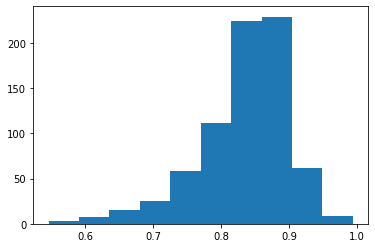

In [18]:
plt.hist(mp_strat_est.propensity_scores)

In [20]:
dwh.print_estimate_comparison(naive_est, mp_strat_est, 'Propensity score stratification')
dwh.print_estimate_comparison(naive_est, data_strat_est, 'Propensity score stratification')
dwh.print_estimate_comparison(naive_est, sdata_strat_est, 'Propensity score stratification')

-------------- Causal Estimates -------------- 
Naive causal estimate is -0.09356128931064231
Propensity score stratification causal estimate is -0.16878726375236355
Percentage change from naive_est: 80.403%
----------------------------------------------
-------------- Causal Estimates -------------- 
Naive causal estimate is -0.09356128931064231
Propensity score stratification causal estimate is -0.056355422568905224
Percentage change from naive_est: -39.766%
----------------------------------------------
-------------- Causal Estimates -------------- 
Naive causal estimate is -0.09356128931064231
Propensity score stratification causal estimate is -0.10269889286565348
Percentage change from naive_est: 9.766%
----------------------------------------------


---
## IV. Refute the obtained estimate


1. **Add Random Common Cause:** Does the estimation method change its estimate after we add an independent random variable as a common cause to the dataset? (Hint: It should not)

In [21]:
mp_ran_strat_refuter = mp_model.refute_estimate(mp_estimand, 
                                                 mp_strat_est, 
                                                 num_simulations=100,
                                                 method_name='random_common_cause')

In [22]:
data_ran_strat_refuter = data_model.refute_estimate(data_estimand, 
                                                 data_strat_est, 
                                                 num_simulations=100,
                                                 method_name='random_common_cause')

In [23]:
sdata_ran_strat_refuter = small_data_model.refute_estimate(small_data_estimand, 
                                                 sdata_strat_est, 
                                                 num_simulations=100,
                                                 method_name='random_common_cause')

In [24]:
print(mp_ran_strat_refuter)
print(data_ran_strat_refuter)
print(sdata_ran_strat_refuter)

Refute: Add a Random Common Cause
Estimated effect:-0.16878726375236355
New effect:-0.1368143662263931

Refute: Add a Random Common Cause
Estimated effect:-0.056355422568905224
New effect:-0.08967701098096684

Refute: Add a Random Common Cause
Estimated effect:-0.10269889286565348
New effect:-0.06934920205208026



2. **Placebo Treatment:** What happens to the estimated causal effect when we replace the true treatment variable with an independent random variable? (Hint: the effect should go to zero)



* Note that the placebo type is 'permute' meaning the rows of the treatment variable have been randomly permuted giving the effect of a placebo treatment.


In [25]:
# Robust if: estimate goes to 0
mp_strat_placebo_refuter = mp_model.refute_estimate(mp_estimand, 
                                                    mp_strat_est, 
                                                    method_name="placebo_treatment_refuter",
                                                    num_simulations=10,
                                                    placebo_type='permute')

In [26]:
data_strat_placebo_refuter = data_model.refute_estimate(data_estimand, 
                                                    data_strat_est, 
                                                    method_name="placebo_treatment_refuter",
                                                    num_simulations=10,
                                                    placebo_type='permute')

In [27]:
sdata_strat_placebo_refuter = small_data_model.refute_estimate(small_data_estimand, 
                                                    sdata_strat_est, 
                                                    method_name="placebo_treatment_refuter",
                                                    num_simulations=10,
                                                    placebo_type='permute')

In [29]:
print(mp_strat_placebo_refuter)
print(data_strat_placebo_refuter)
print(sdata_strat_placebo_refuter)

Refute: Use a Placebo Treatment
Estimated effect:-0.16878726375236355
New effect:-0.004546742629603828
p value:0.4417676283139791

Refute: Use a Placebo Treatment
Estimated effect:-0.056355422568905224
New effect:0.021862614720263275
p value:0.24193327308858742

Refute: Use a Placebo Treatment
Estimated effect:-0.10269889286565348
New effect:0.01308201333211402
p value:0.3344025007605065



3. **Dummy Outcome:** What happens to the estimated causal effect when we replace the true outcome variable with an independent random variable? (Hint: The effect should go to zero)



* The result shows that when using a dummy outcome, the **treatment does not lead to the outcome**. The estimated effect is hence a value that tends to zero, which matches our expectation. This shows that if we replace the outcome by randomly generated data, the **estimator correctly predicts that the influence if treatment is zero**.


In [30]:
# Robust if: estimate goes to 0
mp_strat_dummy_refuter = mp_model.refute_estimate(mp_estimand, 
                                                    mp_strat_est, 
                                                    method_name="dummy_outcome_refuter",
                                                    num_simulations=10)

In [31]:
data_strat_dummy_refuter = data_model.refute_estimate(data_estimand, 
                                                    data_strat_est, 
                                                    method_name="dummy_outcome_refuter",
                                                    num_simulations=10)

In [32]:
sdata_strat_dummy_refuter = small_data_model.refute_estimate(small_data_estimand, 
                                                    sdata_strat_est, 
                                                    method_name="dummy_outcome_refuter",
                                                    num_simulations=10)

In [35]:
print(mp_strat_dummy_refuter[0])
print(data_strat_dummy_refuter[0])
print(sdata_strat_dummy_refuter[0])

Refute: Use a Dummy Outcome
Estimated effect:0
New effect:-0.041312298718632914
p value:0.33572268164114316

Refute: Use a Dummy Outcome
Estimated effect:0
New effect:0.06190318299502886
p value:0.3383524299642783

Refute: Use a Dummy Outcome
Estimated effect:0
New effect:-0.0010403171435045932
p value:0.4961068930940471



4. **Data Subsets Validation:** Does the estimated effect change significantly when we replace the given dataset with a randomly selected subset? (Hint: It should not)

In [46]:
mp_strat_subset_refuter = mp_model.refute_estimate(mp_estimand, 
                                                   mp_strat_est, 
                                                   method_name="data_subset_refuter",
                                                   subset_fraction=0.85,
                                                   num_simulations=10)

In [48]:
data_strat_subset_refuter = data_model.refute_estimate(data_estimand, 
                                                   data_strat_est, 
                                                   method_name="data_subset_refuter",
                                                   subset_fraction=0.85,
                                                   num_simulations=10)

In [47]:
sdata_strat_subset_refuter = small_data_model.refute_estimate(small_data_estimand, 
                                                   sdata_strat_est, 
                                                   method_name="data_subset_refuter",
                                                   subset_fraction=0.85,
                                                   num_simulations=10)

In [49]:
print(mp_strat_subset_refuter)
print(data_strat_subset_refuter)
print(sdata_strat_subset_refuter)

Refute: Use a subset of data
Estimated effect:-0.16878726375236355
New effect:-0.10365601788365923
p value:0.06967886730899499

Refute: Use a subset of data
Estimated effect:-0.056355422568905224
New effect:-0.10086334865982108
p value:0.025826987131844836

Refute: Use a subset of data
Estimated effect:-0.10269889286565348
New effect:-0.09113766570348021
p value:0.3893164258237342



5. **Bootstrap Validation:** Does the estimated effect change significantly when we replace the given dataset with bootstrapped samples from the same dataset? (Hint: It should not)

In [42]:
mp_strat_bootstrap_refuter = mp_model.refute_estimate(mp_estimand, 
                                                   mp_strat_est, 
                                                   method_name="bootstrap_refuter",
                                                   num_simulations=10)

In [43]:
data_strat_bootstrap_refuter = data_model.refute_estimate(data_estimand, 
                                                   data_strat_est, 
                                                   method_name="bootstrap_refuter",
                                                   num_simulations=10)

In [44]:
sdata_strat_bootstrap_refuter = small_data_model.refute_estimate(small_data_estimand, 
                                                   sdata_strat_est, 
                                                   method_name="bootstrap_refuter",
                                                   num_simulations=10)

In [45]:
print(mp_strat_bootstrap_refuter)
print(data_strat_bootstrap_refuter)
print(sdata_strat_bootstrap_refuter)

Refute: Bootstrap Sample Dataset
Estimated effect:-0.16878726375236355
New effect:-0.10136466276582909
p value:0.13941266755277182

Refute: Bootstrap Sample Dataset
Estimated effect:-0.056355422568905224
New effect:-0.13710873430243006
p value:0.07093721615293458

Refute: Bootstrap Sample Dataset
Estimated effect:-0.10269889286565348
New effect:-0.10290368043990294
p value:0.49759297264284497

